# Plotting Results

## 1. Importing dataset

In [1]:
import pickle
from src.data.make_dataset import TextDataset

df = pickle.load(open('../data/interim/text_dataset.pkl', 'rb'))

In [2]:
df.data.head()

,toxic,normal,toxic_reduction,toxic_score,normal_score
5,I'm not gonna have a child... ...with the same...,I'm not going to breed kids with a genetic dis...,0.915109,0.950956,0.035846
6,"They're all laughing at us, so we'll kick your...",they're laughing at us. We'll show you.,0.999361,0.999492,0.000131
7,Maine was very short on black people back then.,there wasn't much black in Maine then.,0.814971,0.963680,0.148710
11,"So now their spirits are cursed, walking back ...","their souls are cursed, they guard the paths, ...",0.698517,0.842509,0.143992
13,"Come on, Cal, leave that shit alone.","come on, Cal, put it down.",0.999357,0.999637,0.000279


## 2. Loading toxicity classifier

In [3]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

clf_name = 's-nlp/roberta_toxicity_classifier_v1'
clf = RobertaForSequenceClassification.from_pretrained(clf_name)
clf_tokenizer = RobertaTokenizer.from_pretrained(clf_name)

Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier_v1 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def compute_toxicity(model, tokenizer, prompts):
    with torch.inference_mode():
        inputs = tokenizer(prompts, return_tensors='pt', padding=True).to(DEVICE)

        out = torch.softmax(model(**inputs).logits, -1)[:, 1].cpu().numpy()

    return out

## 3. Loading GPT-2 based generator

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
from src.models.model_class import GediAdapter

In [6]:
tokenizer_name = "s-nlp/t5-paraphrase-paws-msrp-opinosis-paranmt"
model_name = tokenizer_name
dis_name = 's-nlp/gpt2-base-gedi-detoxification'

device = 'cpu'

In [7]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

NEW_POS = tokenizer.encode('normal', add_special_tokens=False)[0]
NEW_NEG = tokenizer.encode('toxic', add_special_tokens=False)[0]

In [8]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

Embedding(32100, 768)

In [9]:
gedi_dis = AutoModelForCausalLM.from_pretrained(dis_name)

gedi_dis.bias = torch.tensor([[0.08441592, -0.08441573]])
gedi_dis.logit_scale = torch.tensor([[1.2701858]])

gedi_dis.eval()

Some weights of the model checkpoint at s-nlp/gpt2-base-gedi-detoxification were not used when initializing GPT2LMHeadModel: ['bias', 'logit_scale']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(32100, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=32100, bias=False)
)

In [10]:
gedi_adapter = GediAdapter(
    model=model,
    gedi_model=gedi_dis,
    tokenizer=tokenizer,
    gedi_logit_coef=10,
    target=0,
    reg_alpha=3e-5,
    neg_code=NEW_NEG,
    pos_code=NEW_POS,
    ub=0.01
)

In [21]:
from src.models.config import COMMON_GEN_CONF, DEVICE


def process_prompt(model, prompt):
    inputs = model.tokenizer.encode(prompt, return_tensors='pt').to(DEVICE)
    results_raw = model.generate(
        inputs,
        num_return_sequences=1,
        **COMMON_GEN_CONF,
        max_length=100
    )
    results = [
        model.tokenizer.decode(r, skip_special_tokens=True)
        for r in results_raw
    ]

    return results[0]


## 4. Plotting the results

In [22]:
import matplotlib.pyplot as plt

sentences_sample = df.data.sample(n=50)

toxic_sentences = sentences_sample['toxic'].tolist()
normal_sentences = sentences_sample['normal'].tolist()

model_results = [
    process_prompt(gedi_adapter, sent)
    for sent in toxic_sentences
]

model_toxicity = compute_toxicity(clf, clf_tokenizer, model_results)
target_toxicity = compute_toxicity(clf, clf_tokenizer, normal_sentences)
initial_toxiciy = compute_toxicity(clf, clf_tokenizer, toxic_sentences)

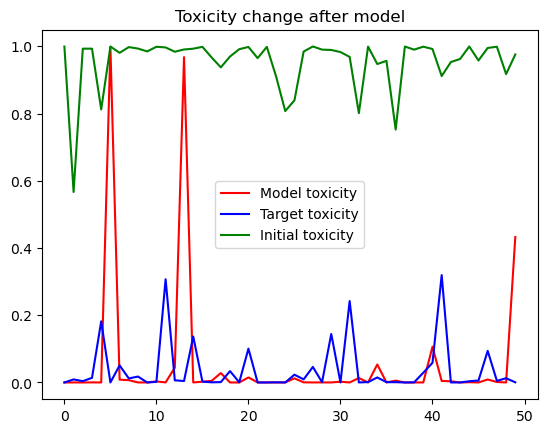

In [23]:
plt.title('Toxicity change after model')
plt.plot(model_toxicity, 'r', label='Model toxicity')
plt.plot(target_toxicity, 'b', label='Target toxicity')
plt.plot(initial_toxiciy, 'g', label='Initial toxicity')
plt.legend()

plt.savefig('../reports/figures/toxicity_change_after_model.png')

plt.show()

In [26]:
print(*sorted(list(zip(toxic_sentences, model_results, initial_toxiciy, model_toxicity)), key=lambda x: x[2] - x[3])[:10], sep='\n')

('shh, shut up.', 'Shut-up.', 0.9994789, 0.9976534)
('"so look, Henry, you bloody verbal plein, I\'m not going to be blackmailed."', '"So look, Henry, bloody verbal plein, I\'m not going to be robbed."', 0.99054366, 0.9678927)
('Murderer Wanted.', 'a Murderer Wanted.', 0.97569567, 0.4327595)
('you guys look like a couple of hot dogs.', 'Looks like a couple of hot dogs.', 0.5666215, 0.00014324154)
('Put a baby inside of me.', 'put the baby inside me.', 0.75244075, 0.0055966927)
('Jesus. You scared the shit out of me.', 'Jesus... You scared me.', 0.8011189, 0.013412761)
('Through streets Cutter had once known now made strange by mortars, with neglected bunting in the colours of factions, with signs proclaiming idiot theories or new churches, new things, new ways of being, split and peeling.', 'through the streets, which Cutter had once known, he now found strange by mortars with neglected ribbons in the colours of factions; signs proclaiming deceptive theories or new churches; new things